In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix


In [2]:
source = pd.read_csv("winequality.csv")

In [3]:
#making copy to reset dataset, if wrongly modified
data = source.copy()

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
data.shape

(1599, 12)

In [6]:
data.isnull().values.sum()

0

## EDA

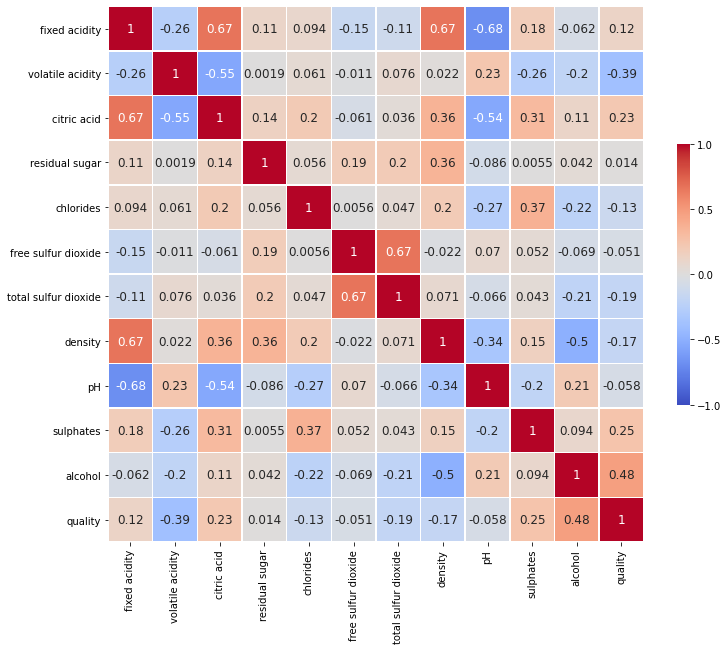

In [7]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(12, 12)) 
heatmap = sns.heatmap(corr_matrix, 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [8]:
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
data['quality'] = pd.cut(data['quality'], bins = bins, labels = group_names)

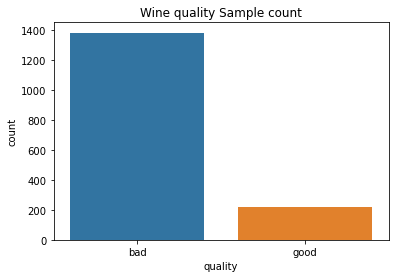

In [9]:
g = sns.countplot(x = 'quality', data =data)
plt.title("Wine quality Sample count")
plt.show(g)

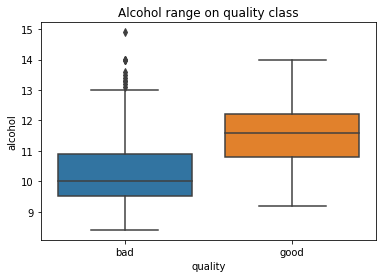

In [10]:
g=sns.boxplot(x="quality", y="alcohol", data=data)
plt.title("Alcohol range on quality class")
plt.show(g)

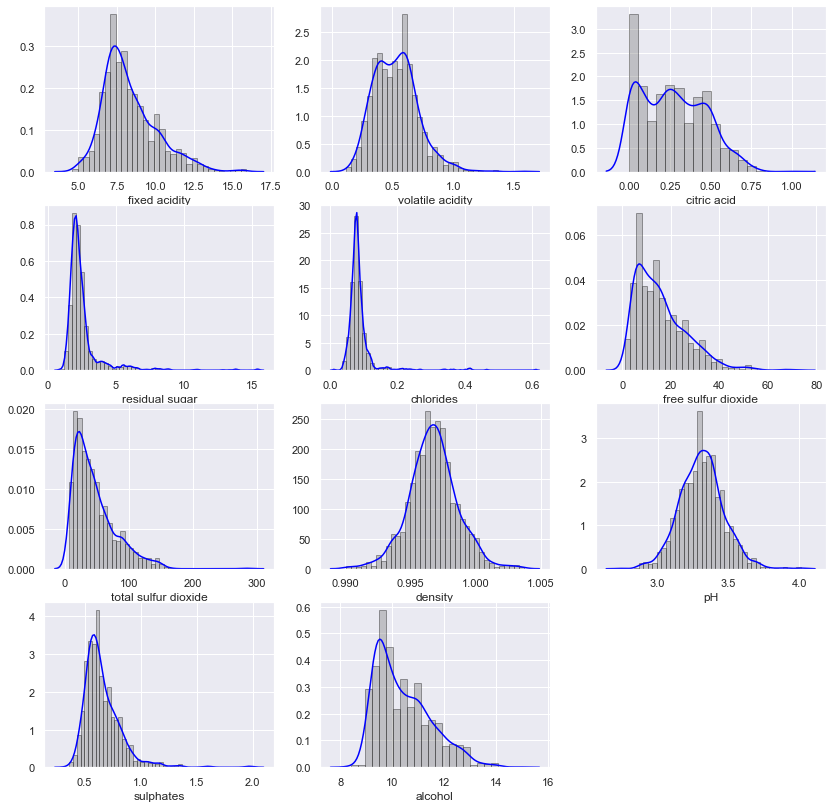

In [11]:
sns.set()
fig = plt.figure(figsize = [14,14])
cols = data.columns[:11]
count = 1
for col in cols :
    plt.subplot(4,3,count)
    sns.distplot(data[col],hist_kws=dict(edgecolor="k", linewidth=1,color='grey'),color='blue')
    count+=1

plt.show() 

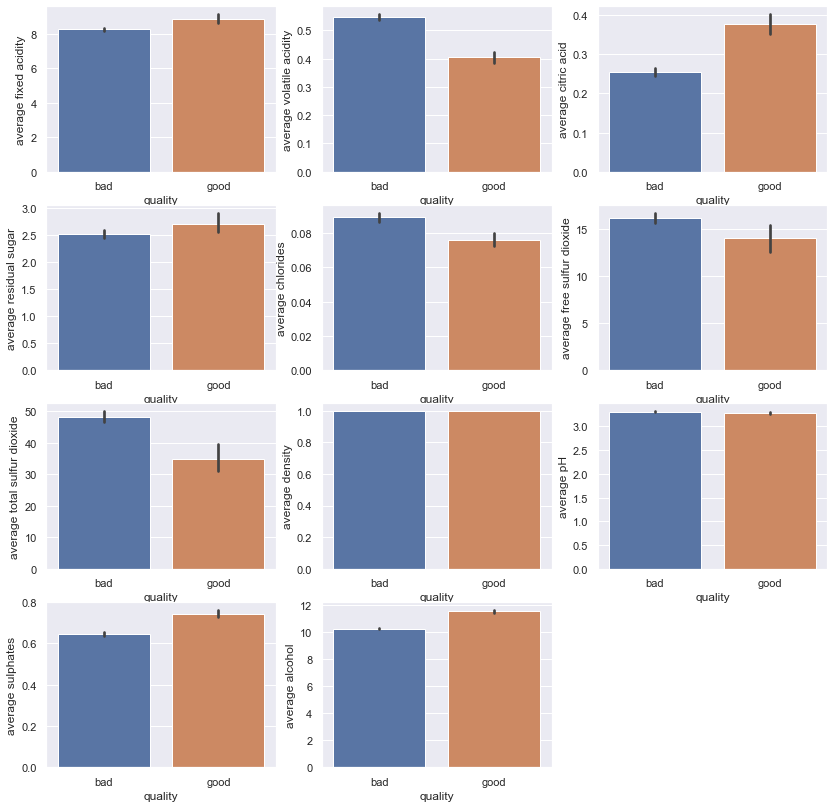

In [12]:
sns.set()
fig = plt.figure(figsize = [14,14])
cols = data.columns[:11]
count = 1
for col in cols :
    plt.subplot(4,3,count)
    sns.barplot(x ='quality', y= col ,data=data)
    count+=1
    plt.ylabel("average {}" . format(col))
plt.show() 

In [13]:
def plotscatter(XA, YA):
    g = sns.scatterplot(x=XA, y=YA, 
             hue="quality", palette=['red','green'], data=data)
    plt.legend(['Bad', 'Good'], loc='upper right', title='Wine Quality')
    plt.title("{} and {} level in Good and Bad wine".format(XA.capitalize(),YA.capitalize()))
    plt.show(g)

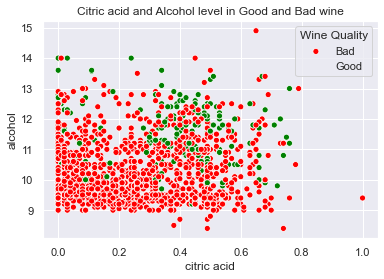

In [14]:
plotscatter("citric acid", "alcohol")

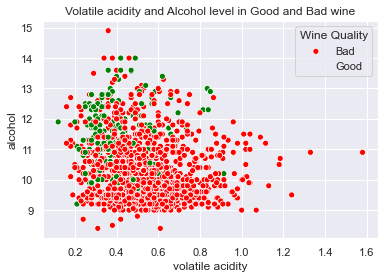

In [15]:
plotscatter("volatile acidity", "alcohol")

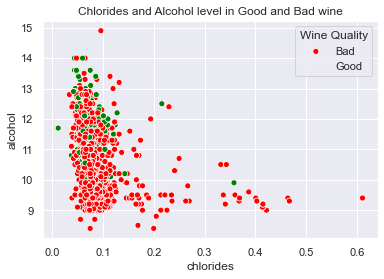

In [16]:
plotscatter("chlorides", "alcohol")

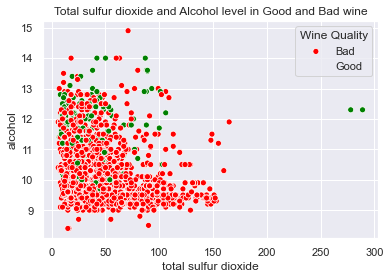

In [17]:
plotscatter("total sulfur dioxide", "alcohol")

In [18]:
encode = LabelEncoder()
data['quality'] = encode.fit_transform(data['quality'])

In [19]:
X = data.drop(columns='quality')
y = data.quality

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 5)

### Defining Pipeline

In [21]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [22]:
pipe1 = Pipeline([('fillna1', imp_mean),
                  ('scale1', StandardScaler()),
                  ('pca1', PCA(n_components=4)),
                  ('Model1', DecisionTreeClassifier())])
pipe2 = Pipeline([('fillna2', imp_mean),
                  ('scale2', StandardScaler()),
                  ('pca2', PCA(n_components=4)),
                  ('Model2', SVC())])
pipe3 = Pipeline([('fillna3', imp_mean),
                  ('scale3', StandardScaler()),
                  ('pca3', PCA(n_components=4)),
                  ('Model3', GradientBoostingClassifier())])
pipe4 = Pipeline([('fillna3', imp_mean),
                  ('scale4', StandardScaler()),
                  ('pca4', PCA()),
                  ('Model4', RandomForestClassifier())])

In [23]:
pipes = [pipe1, pipe2, pipe3, pipe4]
pdict = {0: "DecisionTreeClassifier", 1: 'SupportVectorClassification', 2: 'GradientBoostingClassifier',
         3 : "RandomForestClassifier" }

In [24]:
#defining function to use pipeline
def findbestmodel(Xt,Xtt,yt,ytt):
    
    for pipe in pipes:
            pipe.fit(Xt,yt)
    score = []
    for i, model in enumerate(pipes):
            ypred = model.predict(Xtt)
            score.append(accuracy_score(ytt,ypred))
            print(pdict[i], "Test accuracy is : {:.3f}" .format(score[i]))
            print(pdict[i], "Recall Score is : {:.3f}" .format(recall_score(ytt,ypred), average=None))
            print()
    
    
    importances = pipe.steps[3][1].feature_importances_
    features = Xt.columns
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    #plot_confusion_matrix(pipe.steps[3][1], X_test, y_test, normalize='all', display_labels= {"bad", "good"})
                          

    plt.show()  

DecisionTreeClassifier Test accuracy is : 0.877
DecisionTreeClassifier Recall Score is : 0.597

SupportVectorClassification Test accuracy is : 0.863
SupportVectorClassification Recall Score is : 0.153

GradientBoostingClassifier Test accuracy is : 0.883
GradientBoostingClassifier Recall Score is : 0.417

RandomForestClassifier Test accuracy is : 0.910
RandomForestClassifier Recall Score is : 0.486



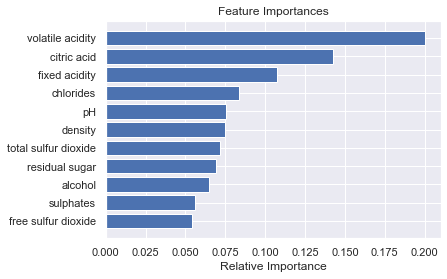

In [25]:
#calling function
findbestmodel(X_train, X_test, y_train, y_test)

Imputer, PCA and scaler were used as component of pipeline with no particular regards to dataset, also sample models were selected randomly for pipeline practice. 